In [1]:
NAME = "" # put your full name here
COLLABORATORS = [] # list names of anyone you worked with on this homework.

# [ERG-131] Homework 2: Pandas EPA Air Quality

---

## Table of Contents
[Introduction](#intro)<br>
1 - [Downloading the Data](#data)<br>
2 - [Preparing the Data](#prep)<br>
3 - [Exploring Data with Pandas](#explore)<br>
4 - [California Data](#cadata)<br>

# Introduction <a id='intro'></a>

In this homework, we will investigate air quality data retreived from the EPA, focusing on using Pandas to analyze particulate matter (PM2.5) levels. This homework is graded based on the total number of correct answers. Each question receives 1 or 2 points. 1 point questions receive full credit if answered correctly.  Otherwise they receive 0 points. 2 point questions receive full credit if answered correctly.  If students make progress on the question but don’t answer correctly they receive 1 point.  Otherwise they receive 0 points.


### Learning Objectives

As we clean and explore these data, by the end of this homework you should be able to:
* Manipulate tables and parts of the table (column, index) using pandas
* Identify the type of data collected, missing values, anomalies, etc. and explain the provenance 
* Compute numeric operations (mean, max, standard deviation) and be able to explain their significance
* Merge data sets and analyze their combined outputs


----

## Section 1: Downloading the Data<a id='data'></a>

Run the cell below to import some of the packages we will need for this assignment:

In [2]:
#Run this cell
from pathlib import Path
import sys
import math
import zipfile
%matplotlib inline
import matplotlib.pyplot as plt

**Question 1.1 (1pt):** Import the Pandas and NumPy libraries `as` their commonly used abbreviations (i.e., `pd`, `np`).   

In [3]:
## YOUR CODE HERE

# Solution
import numpy as np
import pandas as pd

We'll be working with air quality data from the EPA. Have a look at the description of the data  [here](https://aqs.epa.gov/aqsweb/airdata/FileFormats.html#_hourly_data_files).

For this homework, we'll focus on hourly PM2.5 Mass data from 2021. Although it's possible to download the dataset exclusively through the notebook environment, the dataset is too large (over 5.7 million rows!) to load and process in DataHub given the memory constraint. Thus, we'll work with a preprocessed, reduced version of this dataset that removes readings from certain states that we will not be working with.**


** *For your future reference, the raw data can be downloaded from [this website](https://aqs.epa.gov/aqsweb/airdata/download_files.html#Raw). Alternatively, you can directly download a zipfile using a URL in the following form:*

*https://aqs.epa.gov/aqsweb/airdata/hourly_TYPE_YEAR.zip*

...replacing "TYPE" and "YEAR" with the pollutant code and year, respectively, that you want to analyze.

**Measurement | (TYPE)**  
Ozone | (44201)  
SO2 | (42401)  
CO | (42101)  
NO2 | (42602)  
PM2.5 FRM/FEM Mass | (88101)  
PM2.5 non FRM/FEM Mass | (88502)  
PM10 Mass | (81102)  
PM2.5 Speciation | (SPEC)  
PM10 Speciation | (PM10SPEC)

---

Let's start by taking a closer look at the origins of this dataset. Skim the websites above as well as the [documentation for EPA's Air Quality System Database](https://aqs.epa.gov/aqsweb/documents/about_aqs_data.html). Then, answer the following questions:

**Question 1.2 (2 pts):** Do the hourly particulate data from 2021 represent a population or a sample? Justify your answer. 

*YOUR ANSWER HERE*

*Solution*

*These data comprise a **sample** of particulate matter measurements. The documentation indicates that air quality samples are collected via a network of (over 4,000!) sites across the United States, but we don't have observations for locations that are not monitored. In addition, we are only using one year of data (2021), a relatively short snapshot in time.*

**Question 1.3 (2pt):** In 3-5 sentences, summarize the provenance of the hourly particulate data. What can you infer about how the data were collected? What mechanism generated the data? Were the data manipulated (e.g., cleaned, transformed) to before being packaged for download on EPA's website?

*YOUR ANSWER HERE*

*Solution*

*Particulate data are collected by a national network of monitors managed by various state, local, and tribal agencies and reported to the EPA.  The data are observations of local conditions (they are not the result of an experiment or industrial process per se). While the documentation linked above does not describe the data manipulation process specifically for the hourly PM2.5 data, it does reference a "data reduction and aggregation" process that EPA conducts for the AQS data it collects. It is likely the data we are using in this lab have undergone some data handling and manipulation from the raw measurements.*

Now let's take a look at the data itself, using Python to unzip the folder and see how many files it contains:

In [4]:
air_quality_path = Path('data/reduced_PM25_2021.zip')
zf = zipfile.ZipFile(air_quality_path, 'r')
print([f.filename for f in zf.filelist])

['reduced_PM25_2021.csv', '__MACOSX/._reduced_PM25_2021.csv']


We see that there is one visible CSV file within the zip file, and one hidden CSV file (preceded by a "."). Let's ignore this hidden file and focus on the visible CSV.  From here, we want to then get a sense of the structure of the data within the CSV.

**Question 1.4 (1pt):** Read the CSV file from the zip.

In [5]:
# f_name = ...  # REPLACE ELLIPSIS WITH YOUR CODE

#Solution
f_name = 'reduced_PM25_2021.csv'

with zf.open(f_name) as f:
    for i in range(2):
        print(f.readline().rstrip().decode())

"State Code","County Code","Site Num","Parameter Code","POC","Latitude","Longitude","Datum","Parameter Name","Date Local","Time Local","Date GMT","Time GMT","Sample Measurement","Units of Measure","MDL","Uncertainty","Qualifier","Method Type","Method Code","Method Name","State Name","County Name","Date of Last Change"
"06","001","0007","88101",3,37.687526,-121.784217,"WGS84","PM2.5 - Local Conditions","2021-01-01","00:00","2021-01-01","08:00",72,"Micrograms/cubic meter (LC)",5,"","","FEM","170","Met One BAM-1020 Mass Monitor w/VSCC - Beta Attenuation","California","Alameda","2021-05-21"


**Question 1.5 (1pt):** The output of the code above gives us a long list of items. What does this list represent?

*YOUR ANSWER HERE*

SOLUTION:
*The output represents the first two rows of the csv file (the first row is the header).*

#### We can then organize this data and read it more easily by putting it in a table! We will go over this in the next section.

----

## Section 2: Preparing the Data<a id='prep'></a>

We can see that the file contains a pretty descriptive header, and in fact the columns are explained in detail [in the EPA's documentation](https://aqs.epa.gov/aqsweb/airdata/FileFormats.html#_hourly_data_files). Let's extract the data into a Pandas dataframe. We will keep using `zf` to read the file and extract the information.  

In [6]:
# This cell might take a moment to run.
with zf.open(f_name) as fh:
    PM25_2021 = pd.read_csv(fh, low_memory = False)

In [7]:
# Print out the first few rows. 
PM25_2021.head()

,State Code,County Code,Site Num,Parameter Code,POC,Latitude,Longitude,Datum,Parameter Name,Date Local,...,Units of Measure,MDL,Uncertainty,Qualifier,Method Type,Method Code,Method Name,State Name,County Name,Date of Last Change
0,6,1,7,88101,3,37.687526,-121.784217,WGS84,PM2.5 - Local Conditions,2021-01-01,...,Micrograms/cubic meter (LC),5.0,NaN,NaN,FEM,170,Met One BAM-1020 Mass Monitor w/VSCC - Beta At...,California,Alameda,2021-05-21
1,6,1,7,88101,3,37.687526,-121.784217,WGS84,PM2.5 - Local Conditions,2021-01-01,...,Micrograms/cubic meter (LC),5.0,NaN,NaN,FEM,170,Met One BAM-1020 Mass Monitor w/VSCC - Beta At...,California,Alameda,2021-05-21
2,6,1,7,88101,3,37.687526,-121.784217,WGS84,PM2.5 - Local Conditions,2021-01-01,...,Micrograms/cubic meter (LC),5.0,NaN,NaN,FEM,170,Met One BAM-1020 Mass Monitor w/VSCC - Beta At...,California,Alameda,2021-05-21
3,6,1,7,88101,3,37.687526,-121.784217,WGS84,PM2.5 - Local Conditions,2021-01-01,...,Micrograms/cubic meter (LC),5.0,NaN,NaN,FEM,170,Met One BAM-1020 Mass Monitor w/VSCC - Beta At...,California,Alameda,2021-05-21
4,6,1,7,88101,3,37.687526,-121.784217,WGS84,PM2.5 - Local Conditions,2021-01-01,...,Micrograms/cubic meter (LC),5.0,NaN,NaN,FEM,170,Met One BAM-1020 Mass Monitor w/VSCC - Beta At...,California,Alameda,2021-05-21


**Question 2.1 (1 pt):** Name one column that contains the integer data, one column that contains the float data, and one column that contains string data. Explain what each of these datatypes are. (Hint: the [Pandas dtypes](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dtypes.html) method might be useful here).

*YOUR ANSWER HERE*
Float:
String:
Integer:

*Solution* 

*Many answers are acceptable, as long as they are consistent with the data types in the table.*
Float: Number with decimals
String: Anything with words
Integer: Number without any decimals

In [8]:
# Use this cell for scratch work

In [9]:
# Solution scratch work
print(PM25_2021.dtypes) # Check the datatypes for each column.
print(type(PM25_2021['Units of Measure'][0])) # Verify that one or more of the columns with "object" dtype contains strings.
print(type(PM25_2021['Time Local'][0]))

State Code               int64
County Code              int64
Site Num                 int64
Parameter Code           int64
POC                      int64
Latitude               float64
Longitude              float64
Datum                   object
Parameter Name          object
Date Local              object
Time Local              object
Date GMT                object
Time GMT                object
Sample Measurement     float64
Units of Measure        object
MDL                    float64
Uncertainty            float64
Qualifier               object
Method Type             object
Method Code              int64
Method Name             object
State Name              object
County Name             object
Date of Last Change     object
dtype: object
<class 'str'>
<class 'str'>


**Question 2.2 (2pt):** Identify at least one issue relating to questionable or missing data in the dataframe, and outline (in one sentence) how this data-related issue could impact an analyst's ability to draw conclusions from the data. Come up with at least one possible solution for this issue.

*YOUR ANSWER HERE*

*Answers can vary, but one answer is: the air quality uncertainty field ("Uncertainty") contains a lot of NaNs, which would make it difficult to compare air quality at different times or in different locations with any certainty. It is possible to do this analysis without that uncertainty field, or to only work with data with known uncertainty.* 

**Question 2.3 (3 pts):** Answer the questions below. (*Hint*: the method `.shape` might be helpful for answering the first two questions.)

1. How many records are present?
2. How many fields are reported?
3. What does each row represent?

In [10]:
# use this cell for scratch work

In [11]:
# Solution scratch work
PM25_2021.shape

(839365, 24)

*YOUR ANSWER HERE*

*There are 839,365 records and 24 fields (corresponding to the number of rows and columns in the dataframe). Each row is a PM2.5 measurement at a given hour and monitor location.*

**Question 2.4 (1 pt):** After reading up on the metadata [here](https://aqs.epa.gov/aqsweb/airdata/FileFormats.html#_hourly_data_files), what does MDL stand for and what is it?  

*YOUR ANSWER HERE*

*MDL stands for Method Detection Limit, the minimum concentration that the monitor and method used at a given station can measure.*

**Question 2.5 (2pts):** What percentage of the records in the `PM25_2021` dataframe have a smaller sample measurement than they do an MDL value? Are you more or less confident in those values than you are in the sample measurement values in the rest of the dataset? Why?

In [12]:
# use this cell for scratch work

In [13]:
# Solution scratch work 
under_MDL = len(PM25_2021[PM25_2021["Sample Measurement"]<PM25_2021["MDL"]])
under_MDL / len(PM25_2021) * 100

24.74716005551816

*YOUR ANSWER HERE*

*The sample measurement is lower than the MDL for about 25% of records. We would have less confidence in those values, since they fall below the lower limit for which the monitor can provide reliable information.*

**Question 2.6 (1pt):** Let's look at some of the fields that identify location. 
1. How many unique states are represented in `PM25_2021`? Which ones are they?
2. How many counties? 
3. How many unique values of the site-identifying variable `Site Num` are there? 


In [14]:
# scratch work here

In [15]:
# Solution scratch work
unique_states = PM25_2021["State Name"].unique()
print(len(unique_states))
print(unique_states)

print(len(PM25_2021["County Name"].unique()))

print(len(PM25_2021["Site Num"].unique()))
# or 
print(len(PM25_2021[['Site Num']].value_counts().sort_values(ascending=False)))


1
['California']
43
53
53


*YOUR ANSWER HERE*

*Solution*

*One state (California) is represented in the dataframe. There are 43 counties present, and 53 different Site Num values.*

**Question 2.7 (2pt):** Revisit the metadata [here](https://aqs.epa.gov/aqsweb/airdata/FileFormats.html#_hourly_data_files) to look up the description of the `Site Num` variable. Is the number of monitoring site locations in this dataset necessarily the same as your answer to part 3 of the question above? How might you use additional variables to confirm the number of distinct monitoring site locations that this dataset contains? Hint: you may find the [.value_counts()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.value_counts.html) or [.drop_duplicates()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop_duplicates.html) methods useful). 

In [16]:
# scratch work here

In [17]:
# Solution scratch work

# Number of unique Site Num 
print(len(PM25_2021['Site Num'].unique()))

# One approach to get unique sites
site_county = PM25_2021[['County Name','Site Num']]
site_county = site_county.drop_duplicates()
print(site_county.groupby('County Name').count().sum())

# Another approach
site_counts = PM25_2021[["County Name","Site Num"]].value_counts()
site_counts.sort_values(ascending=False, inplace=True)
print(site_counts.shape)

# A third approach
print(len(PM25_2021['Latitude'].unique()))
print(len(PM25_2021['Longitude'].unique()))

# A fourth approach: 
latlon_counts = PM25_2021[["Latitude","Longitude"]].value_counts()
print(latlon_counts.shape)

53
Site Num    103
dtype: int64
(103,)
103
103
(103,)


*YOUR ANSWER HERE*

*Solution*

*The `Site Num` values are county-specific, so if two different counties use the same `Site Num` value for different monitoring sites, those two sites will have the same `Site Num` value. To identify the number of distinct monitoring sites, you might count the number of unique `Site Num` values per county, and sum these across counties. You also might look at the distinct `Latitude` and `Longitude` values to estimate the number of distinct sites.*

**Question 2.8 (2pts):** We are not going to need the `Site Num` column for this data analysis; indeed, many of these columns will be unnecessary for this analysis. Let's make a new dataframe (called `df`) with the information we need. Use pd.DataFrame to create a new table with 6 columns, ***named and ordered*** as follows:

1. `County`: The **name** of the county where the monitoring site is located.
1. `Time`: The time of day that sampling began on a 24-hour clock, corresponding to the `Time Local` column.
1. `Date`: The column of dates corresponding to the `Date Local` column.
1. `MDL`: the method detection limit for the measurement.
1. `Measurement`: The measured value in the standard units of measure for the parameter corresponding to the `Sample Measurement` column.
1. `Units`: The unit of measure for the parameter corresponding to the `Units of Measure` column.

In [18]:
df = ... # YOUR CODE HERE

In [19]:
# Solution
df = pd.DataFrame(columns = ["County","Time", "Date","MDL", "Measurement", "Units"])

df["Date"]= PM25_2021["Date Local"]
df["Time"]= PM25_2021["Time Local"]
df["Measurement"]= PM25_2021["Sample Measurement"]
df["Units"]= PM25_2021["Units of Measure"]
df["County"]= PM25_2021["County Name"]
df["MDL"] = PM25_2021["MDL"]

In [20]:
# Print a few rows. 
df.iloc[80:90,:]

,County,Time,Date,MDL,Measurement,Units
80,Alameda,08:00,2021-01-04,5.0,8.0,Micrograms/cubic meter (LC)
81,Alameda,09:00,2021-01-04,5.0,2.0,Micrograms/cubic meter (LC)
82,Alameda,10:00,2021-01-04,5.0,-1.0,Micrograms/cubic meter (LC)
83,Alameda,11:00,2021-01-04,5.0,0.0,Micrograms/cubic meter (LC)
84,Alameda,12:00,2021-01-04,5.0,9.0,Micrograms/cubic meter (LC)
85,Alameda,13:00,2021-01-04,5.0,7.0,Micrograms/cubic meter (LC)
86,Alameda,14:00,2021-01-04,5.0,3.0,Micrograms/cubic meter (LC)
87,Alameda,15:00,2021-01-04,5.0,4.0,Micrograms/cubic meter (LC)
88,Alameda,16:00,2021-01-04,5.0,4.0,Micrograms/cubic meter (LC)
89,Alameda,17:00,2021-01-04,5.0,7.0,Micrograms/cubic meter (LC)


**Question 2.9a (1pt)** It appears that some rows of `Measurement` contain negative values; perhaps surprising for a physical quantity with units of "Micrograms/cubic meter." Let's use the `MDL` variable to "clean" our `Measurement` variable. For all rows of `df` where `Measurement` is lower than `MDL`, replace the value of `Measurement` in those rows with `np.nan` (the `.loc` method is helpful here!).

*Hint / Warning*: You may get a "SettingWithCopyWarning".  It's ok to ignore.  

In [21]:
# YOUR CODE HERE

In [22]:
# Solution
df.loc[df['Measurement']<df['MDL'], 'Measurement'] = np.nan 

In [23]:
# Print a few rows to check that your method worked.
df.iloc[80:90,:]

,County,Time,Date,MDL,Measurement,Units
80,Alameda,08:00,2021-01-04,5.0,8.0,Micrograms/cubic meter (LC)
81,Alameda,09:00,2021-01-04,5.0,NaN,Micrograms/cubic meter (LC)
82,Alameda,10:00,2021-01-04,5.0,NaN,Micrograms/cubic meter (LC)
83,Alameda,11:00,2021-01-04,5.0,NaN,Micrograms/cubic meter (LC)
84,Alameda,12:00,2021-01-04,5.0,9.0,Micrograms/cubic meter (LC)
85,Alameda,13:00,2021-01-04,5.0,7.0,Micrograms/cubic meter (LC)
86,Alameda,14:00,2021-01-04,5.0,NaN,Micrograms/cubic meter (LC)
87,Alameda,15:00,2021-01-04,5.0,NaN,Micrograms/cubic meter (LC)
88,Alameda,16:00,2021-01-04,5.0,NaN,Micrograms/cubic meter (LC)
89,Alameda,17:00,2021-01-04,5.0,7.0,Micrograms/cubic meter (LC)


**Question 2.9b (1pt):** How many rows now have a valid numerical measurement? Hint: the [`.isnull()`](https://pandas.pydata.org/docs/reference/api/pandas.isnull.html) method might be useful here.)

In [24]:
# scratch work here

*YOUR ANSWER HERE*

In [25]:
# Solution
print(len(df) - len(df.loc[df['Measurement'].isnull()]))

631646


**Question 2.10 (2pts):** We could have used a different strategy to 'clean' the measurements with values below the MDL. Why might it be a good idea to replace these measurements with "NaN" rather than setting them to another value, e.g., 0 or to the MDL? Similarly, why might we want to use "NaN" instead of removing these rows from the table entirely?

*YOUR ANSWER HERE*

*SOLUTION*

*By filling questionable measurements with np.nan instead another number, we avoid creating confusion between actual measurements and "fill" values that we manually impose on the dataset and preserve our ability take statistics such as mean, max, and min values. Similarly, by using np.nan instead of deleting these rows, we retain the record (as distinct from a failure by the sensor to record a measurement) but are able to exclude its value from any calculations.* 

<br>

----

## Section 3: Exploring Data with Pandas<a id='explore'></a>

In this section we will analyze the EPA data to examine how air pollution in Sacramento varies over the course of the day.

**Question 3.1 (1pt):** Starting with the dataframe `df` from Question 2.6, create a new table containing just data from Sacramento county in California.

In [26]:
sac = ... # YOUR CODE HERE

In [27]:
# Solution
sac = df[(df['County']=='Sacramento')]

In [28]:
# Print the first few rows.
sac.head(10)

,County,Time,Date,MDL,Measurement,Units
452590,Sacramento,00:00,2021-01-01,5.0,16.0,Micrograms/cubic meter (LC)
452591,Sacramento,01:00,2021-01-01,5.0,40.0,Micrograms/cubic meter (LC)
452592,Sacramento,02:00,2021-01-01,5.0,36.0,Micrograms/cubic meter (LC)
452593,Sacramento,03:00,2021-01-01,5.0,16.0,Micrograms/cubic meter (LC)
452594,Sacramento,04:00,2021-01-01,5.0,12.0,Micrograms/cubic meter (LC)
452595,Sacramento,05:00,2021-01-01,5.0,15.0,Micrograms/cubic meter (LC)
452596,Sacramento,06:00,2021-01-01,5.0,15.0,Micrograms/cubic meter (LC)
452597,Sacramento,07:00,2021-01-01,5.0,13.0,Micrograms/cubic meter (LC)
452598,Sacramento,08:00,2021-01-01,5.0,18.0,Micrograms/cubic meter (LC)
452599,Sacramento,09:00,2021-01-01,5.0,18.0,Micrograms/cubic meter (LC)


In [29]:
len(sac)

50105

In [30]:
assert len(sac) == 50105 

**Question 3.2 (1pt):** Use the `.describe` method to print some statistics summarizing the measurements in Sacramento taken at 5:00am and the measurements taken at 5:00pm. Comment on the differences between 5am and 5pm using the output of the `.describe` method. 

In [31]:
# measurements at 6am

#YOUR CODE HERE

In [32]:
# Solution

sac_am = sac[sac['Time']=='05:00']
sac_am.describe()

,MDL,Measurement
count,2101.000000,1478.000000
mean,4.487387,12.857307
std,1.129457,29.026047
min,2.000000,2.000000
25%,5.000000,6.000000
50%,5.000000,8.000000
75%,5.000000,13.000000
max,5.000000,628.000000


In [33]:
# Measurements at 6pm

# YOUR CODE HERE

In [34]:
# Solution
sac_pm = sac[sac['Time']=='17:00']
sac_pm.describe()

,MDL,Measurement
count,2103.000000,1436.000000
mean,4.486448,12.056128
std,1.130278,12.196431
min,2.000000,2.000000
25%,5.000000,6.000000
50%,5.000000,8.000000
75%,5.000000,14.000000
max,5.000000,128.000000


YOUR ANSWER HERE

*SOLUTION*

*The values for MDL are almost identical, except for the mean. The measurement values are mo difference, with the maximum measurement at 5am being much high than the maximum measurement at 5pm, even though the mean values are the same.* 

**Question 3.3 (1pt):** We can also visualize this data and see how the PM2.5 concentrations fluctuate throughout the day. Start by using the `groupby` method to find the mean PM2.5 measurement for each hour of the day. The result should be a dataframe in which the indices are the 24 hours of the day (00:00 - 23:00) and the columns are `Measurement` and `MDL`.

In [35]:
# YOUR CODE HERE
sac_hr = ...

In [36]:
# Solution:
sac_hr = sac.groupby('Time').mean()

In [37]:
assert sac_hr.shape == (24, 2)

**Question 3.4 (2pts):** Now, run the code in the cell below to plot the mean PM2.5 for each hour. The x-axis should be the hour of the day (00:00 - 23:00). Label the y-axis. Are there any noticeable trends in this plot?

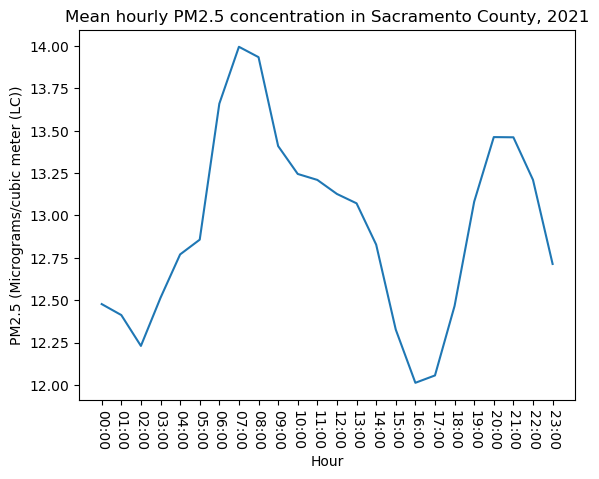

In [38]:
plt.plot(sac_hr.index, sac_hr['Measurement'])
plt.xticks(rotation=270)
plt.title('Mean hourly PM2.5 concentration in Sacramento County, 2021')
plt.xlabel('Hour')
# Add a y-axis label

# SOLUTION
plt.ylabel('PM2.5 (Micrograms/cubic meter (LC))') 
# END SOLUTION

plt.show()

*YOUR OBSERVATIONS HERE*

*One point for labeling the y-axis, one point for describing the curve. Notice that the morning PM2.5 is higher on average than the evening PM2.5.*

**Question 3.5 (1pt):** Use the `groupby` method on the `sac` dataframe once again, but this time, use the standard deviation (`std()`) aggregation function. 

In [39]:
# YOUR CODE HERE
sac_stdev = ...

In [40]:
# SOLUTION
sac_stdev = sac.groupby('Time').std()
sac_stdev

,MDL,Measurement
Time,,
00:00,1.131169,10.973390
01:00,1.129918,12.069768
02:00,1.131384,13.929170
03:00,1.128022,19.564312
04:00,1.127808,26.619212
05:00,1.129457,29.026047
06:00,1.130918,34.617750
07:00,1.130278,31.258366
08:00,1.125117,28.819182


**Question 3.6 (2pts):** Run the code below to plot the standard deviation on the same graph as the mean data. Label the y-axis and title the plot. Record your observations.

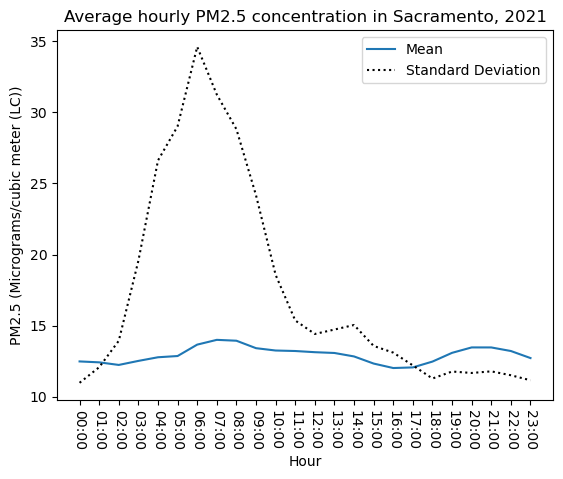

In [41]:
plt.plot(sac_hr.index, sac_hr['Measurement'], label = 'Mean')
plt.plot(sac_stdev.index, sac_stdev['Measurement'], 'k:', label = 'Standard Deviation')
plt.xticks(rotation=270)
plt.xlabel('Hour')
# Add a y-axis label
# Add a plot title

# Solution
plt.title('Average hourly PM2.5 concentration in Sacramento, 2021')
plt.ylabel('PM2.5 (Micrograms/cubic meter (LC))') 
# Solution end

plt.legend();

*YOUR OBSERVATIONS HERE*

*One point for labelling the title and y-axis, one point for making an accurate observation about the standard deviation.*

**Question 3.7 (2pts):** Do the data support the hypothesis that PM2.5 concentrations follow a diurnal pattern? Why or why not? What are some of the limitations of either our data or the methods we've used to explore it so far in allowing us to observe hourly trends?

*YOUR ANSWER HERE*

*A variety of answers were accepted here. Key points: looking only at the means, there does appear to be a diurnal pattern (morning concentrations are higher than evening concentrations), but the high standard deviation calls into question any inference we could make looking at mean alone. Limitations: we aren't analyzing seasons, weekends versus weekdays, weather or fire conditions...*

**Question 3.8 (2pts):** In Susan Athey's essay "Beyond Prediction", Athey defines the distinction between prediction problems and causal inference problems. Thinking about this air quality dataset, can you come up with one question that poses a prediction problem (also referred to as a resource allocation problem in the essay) and another that poses a causal inference problem? The two questions you come up with should be air quality related, but you don't have to limit yourself to this dataset (eg. it's totally fair to come up with a question that would also incorporate, for example, census or demographic data).

*YOUR ANSWER HERE*

*A variety of answers were accepted here, but the wording of the prediction question needed to make it clear that the focus is on the response variable (i.e., air pollution) rather than the predictor (e.g., traffic, point sources). Full credit answers asked a resource allocation question, e.g., "Where and when should we target a program distributing free N95 masks?"*

## Section 4: California wildfire impacts 

Let's explore the dynamics of wildfire and air quality. In this section, we will use data analysis to see how a major wildfire impacted PM2.5 concentrations in Butte County in 2021. 


**Question 4.1 (1pt)** Using the dataframe `df` from above that contained PM2.5 information for many counties, use `group_by` to find the maximum PM2.5 concentration recorded in each county in 2021. 

In [42]:
# YOUR CODE HERE

In [43]:
# Solution
df.groupby(by = 'County').max().sort_values('Measurement',ascending=False)

,Time,Date,MDL,Measurement,Units
County,,,,,
Tulare,23:00,2021-12-31,5.0,733.0,Micrograms/cubic meter (LC)
Sacramento,23:00,2021-12-31,5.0,678.0,Micrograms/cubic meter (LC)
Nevada,23:00,2021-12-31,5.0,551.0,Micrograms/cubic meter (LC)
San Bernardino,23:00,2021-12-31,5.0,549.0,Micrograms/cubic meter (LC)
Inyo,23:00,2021-12-31,2.0,515.2,Micrograms/cubic meter (LC)
San Joaquin,23:00,2021-12-31,5.0,500.4,Micrograms/cubic meter (LC)
Shasta,23:00,2021-12-31,5.0,459.0,Micrograms/cubic meter (LC)
Calaveras,23:00,2021-12-31,2.0,433.0,Micrograms/cubic meter (LC)
Orange,23:00,2021-12-31,5.0,302.4,Micrograms/cubic meter (LC)


The [Dixie Fire](https://www.cbsnews.com/sacramento/news/dixie-fire-100-percent-contained-after-storm/) was the second largest wildfire in California history. It started on July 13, 2021 when a tree contacted PG&E electrical distribution lines in Butte county (see the [CAL FIRE news release](https://www.fire.ca.gov/programs/communications/) from January 2022: *CAL FIRE Investigators Determine Cause of the Dixie Fire*). The fire burned 963,309 acres across Butte, Plumas, Lassen, Shasta, and Tehama counties, and caused unhealthy air quality across the Western US.

**Question 4.2 (1pt)** Create a dataframe called `shasta` that is a subset of `df` and just contains PM2.5 data for Shasta County.

In [44]:
# YOUR CODE HERE
shasta = ... 

In [45]:
# Solution
shasta = df[df["County"] == "Shasta"]

In [46]:
assert shasta.shape == (8306,6)

**Question 4.3 (1pt)** Use `groupby` to determine the date on which Shasta county experienced its worst air quality, i.e., the day with the highest mean concentration of PM2.5.

In [47]:
# YOUR CODE HERE
daily_means = ... # Find the mean hourly PM2.5 concentration for every day of the year
worst_day = ... # Determine the date with the highest mean PM2.5 concentration
worst_day 

Ellipsis

In [48]:
# SOLUTION
daily_means = shasta.groupby('Date').mean()
worst_day = daily_means.loc[daily_means['Measurement']==daily_means['Measurement'].max()]
worst_day

# # Calculate top 5 worst days
# print(type(daily_means['Measurement'].sort_values(ascending=False)))

,MDL,Measurement
Date,,
2021-08-17,5.0,168.45


**Question 4.4 (1pt)** Identify the daily mean PM2.5 concentration in Shasta county on the top 5 worst air quality days. How do these PM2.5 concentrations compare to the top 5 best air quality days?  (`sort_values` may be helpful): 

In [49]:
# YOUR CODE HERE

YOUR ANSWER HERE

In [50]:
# SOLUTION
print(daily_means.sort_values(by="Measurement",ascending=False).head(5))
print(daily_means.sort_values(by="Measurement",ascending=True).head(5))

            MDL  Measurement
Date                        
2021-08-17  5.0   168.450000
2021-08-16  5.0   165.347826
2021-08-15  5.0   151.208333
2021-08-07  5.0   150.333333
2021-08-06  5.0   126.333333
            MDL  Measurement
Date                        
2021-10-15  5.0          5.0
2021-06-14  5.0          5.0
2021-10-18  5.0          5.0
2021-06-11  5.0          5.0
2021-09-28  5.0          5.0


*SOLUTION*

*The 5 worst air quality days have a concentration above 100, and the best days all have a concentration of 5.*

Compare the hourly air quality in Shasta County just after the fire started (let's use July 15, 2021), with the hourly air quality in Shasta a month later on August 15, 2021. 


**Question 4.5 (1pt)** Using `shasta`, create one table `sc_jul15` containing just information from Shasta County on July 15, 2021, and another table `sc_aug15` containing just information from Shasta County on August 15, 2021.

In [51]:
# YOUR CODE HERE
sc_jul15 = ...
sc_aug15 = ...

In [52]:
# SOLUTION
sc_jul15 = shasta[(shasta['Date'] == '2021-07-15')]
sc_aug15 = shasta[(shasta['Date'] == '2021-08-15')]

In [53]:
sc_jul15.head()

,County,Time,Date,MDL,Measurement,Units
690350,Shasta,00:00,2021-07-15,5.0,9.0,Micrograms/cubic meter (LC)
690351,Shasta,01:00,2021-07-15,5.0,8.0,Micrograms/cubic meter (LC)
690352,Shasta,02:00,2021-07-15,5.0,9.0,Micrograms/cubic meter (LC)
690353,Shasta,03:00,2021-07-15,5.0,7.0,Micrograms/cubic meter (LC)
690354,Shasta,04:00,2021-07-15,5.0,8.0,Micrograms/cubic meter (LC)


In [54]:
sc_aug15.head()

,County,Time,Date,MDL,Measurement,Units
691093,Shasta,00:00,2021-08-15,5.0,136.0,Micrograms/cubic meter (LC)
691094,Shasta,01:00,2021-08-15,5.0,141.0,Micrograms/cubic meter (LC)
691095,Shasta,02:00,2021-08-15,5.0,135.0,Micrograms/cubic meter (LC)
691096,Shasta,03:00,2021-08-15,5.0,131.0,Micrograms/cubic meter (LC)
691097,Shasta,04:00,2021-08-15,5.0,129.0,Micrograms/cubic meter (LC)


**Question 4.6 (2pt):** Merge `sc_jul15` and `sc_aug15` on `Time` to compare their PM2.5 concentrations side by side. Rename your `Measurement` columns to make it clear which column responds to the July 15th values vs. the August 15th values. 

*Note:* If two dataframes have the same column names when pandas executes a merge, it will append a '_x' to the first dataframe's column names and a '_y' to the second dataframe's column names. The rename operation is meant to clarify things. Be sure that it's renaming correctly!

In [55]:
# YOUR CODE HERE
sc_merge = ... # Merge sc_jul15 and sc_aug15 on `Time`
 # rename columns
# sc_merge.head()

In [56]:
# SOLUTION
sc_merge = sc_jul15.merge(sc_aug15,on='Time')
sc_merge.rename(columns={'Measurement_x':'Jul15 PM2.5', 'Measurement_y':'Aug15 PM2.5'},inplace=True)
sc_merge

,County_x,Time,Date_x,MDL_x,Jul15 PM2.5,Units_x,County_y,Date_y,MDL_y,Aug15 PM2.5,Units_y
0,Shasta,00:00,2021-07-15,5.0,9.0,Micrograms/cubic meter (LC),Shasta,2021-08-15,5.0,136.0,Micrograms/cubic meter (LC)
1,Shasta,01:00,2021-07-15,5.0,8.0,Micrograms/cubic meter (LC),Shasta,2021-08-15,5.0,141.0,Micrograms/cubic meter (LC)
2,Shasta,02:00,2021-07-15,5.0,9.0,Micrograms/cubic meter (LC),Shasta,2021-08-15,5.0,135.0,Micrograms/cubic meter (LC)
3,Shasta,03:00,2021-07-15,5.0,7.0,Micrograms/cubic meter (LC),Shasta,2021-08-15,5.0,131.0,Micrograms/cubic meter (LC)
4,Shasta,04:00,2021-07-15,5.0,8.0,Micrograms/cubic meter (LC),Shasta,2021-08-15,5.0,129.0,Micrograms/cubic meter (LC)
5,Shasta,05:00,2021-07-15,5.0,5.0,Micrograms/cubic meter (LC),Shasta,2021-08-15,5.0,125.0,Micrograms/cubic meter (LC)
6,Shasta,06:00,2021-07-15,5.0,6.0,Micrograms/cubic meter (LC),Shasta,2021-08-15,5.0,130.0,Micrograms/cubic meter (LC)
7,Shasta,07:00,2021-07-15,5.0,14.0,Micrograms/cubic meter (LC),Shasta,2021-08-15,5.0,138.0,Micrograms/cubic meter (LC)
8,Shasta,08:00,2021-07-15,5.0,13.0,Micrograms/cubic meter (LC),Shasta,2021-08-15,5.0,147.0,Micrograms/cubic meter (LC)
9,Shasta,09:00,2021-07-15,5.0,10.0,Micrograms/cubic meter (LC),Shasta,2021-08-15,5.0,163.0,Micrograms/cubic meter (LC)


**Question 4.7 (2pt):** Calculate the mean PM2.5 measurement on both days. Using [EPA's air quality index](https://www.airnow.gov/aqi/aqi-basics/), comment on the relative level of health concern for each day.


In [57]:
# YOUR CODE HERE

In [58]:
# SOLUTION
sc_jul15_mean = sc_merge['Jul15 PM2.5'].mean()
sc_aug15_mean = sc_merge['Aug15 PM2.5'].mean()

print(sc_jul15_mean)
print(sc_aug15_mean)

8.590909090909092
151.20833333333334


*YOUR ANSWER HERE*


*SOLUTION* 

*EPA AQI measure on 15-Jul-2021 is in the green zone "Level of Concern=Good"; "Air quality is satisfactory, and air pollution poses little or no risk."*

*EPA AQI measure on 15-Aug-2021 is in the red zone "Level of Concern=Unhealthy"; "Some members of the general public may experience health effects; members of sensitive groups may experience more serious health effects."*


**Question 4.8 (2pts for completion):** Read this article [Managing the growing cost of wildfire](https://siepr.stanford.edu/publications/policy-brief/managing-growing-cost-wildfire), and answer the following questions:

How should policymakers decide where and how to spend money to reduce PM2.5 pollution impacts due to wildfires? Provide one example of a prediction question you could answer that would help policy makers know if they are using their resources (money, time, etc.) effectively to reduce PM2.5 pollution from wildfires.

*YOUR ANSWER HERE*

*SOLUTION*

*Policymakers should create a comprehensive plan to evaluate when and where wildfire smoke is dispersed, and then study the individuals that are within range of PM2.5 pollution afterwards. One potential prediction question is – what level of PM2.5 pollution causes adverse effects on individuals?*

----

## Submission

Congrats, you're done with homework 2!

Before you submit, click **Kernel** --> **Restart & Clear Output**. Then, click **Cell** --> **Run All**. Then, go to the toolbar and click **File** -> **Download as** -> **.pdf** and submit the file through bCourses.

---
Adapted from a notebook developed by: Melissa Ly

Data Science Modules: http://data.berkeley.edu/education/modules